# Data Preparation (Molecular Descriptors)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
trn_dirty = pd.read_csv("../data/SMILES/TRN_dirty.csv")
trn_dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11612 entries, 0 to 11611
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        11612 non-null  object 
 1   SMILES      11533 non-null  object 
 2   Solubility  11610 non-null  float64
 3   Set         11612 non-null  object 
 4   Ref         11612 non-null  object 
 5   MW          11612 non-null  float64
dtypes: float64(2), object(4)
memory usage: 544.4+ KB


Remove entries with null SMILES or null Solubility values.

In [3]:
trn_dirty.dropna(subset=['SMILES', 'Solubility'], inplace=True)
trn_dirty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11531 entries, 0 to 11611
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        11531 non-null  object 
 1   SMILES      11531 non-null  object 
 2   Solubility  11531 non-null  float64
 3   Set         11531 non-null  object 
 4   Ref         11531 non-null  object 
 5   MW          11531 non-null  float64
dtypes: float64(2), object(4)
memory usage: 630.6+ KB


<Axes: xlabel='Log $S$ exp (mol/L)', ylabel='Count'>

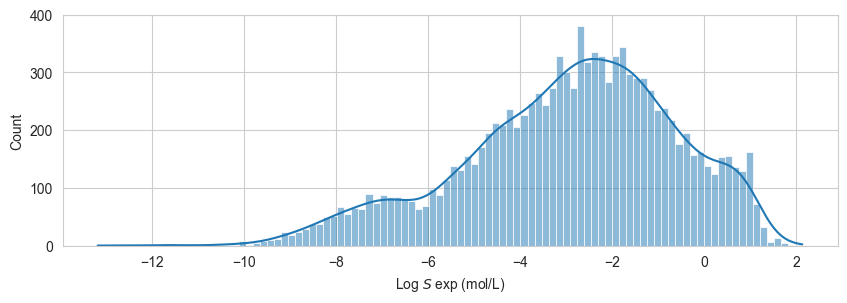

In [4]:
fig, ax = plt.subplots(figsize=(10, 3))
distribution = sns.histplot(trn_dirty["Solubility"], kde=True, bins=100, ax=ax)
distribution.set(xlabel="Log $S$ exp (mol/L)")
distribution

## Mitigate the risk of pollution

In the absence of a straightforward criterion for defining and identifying duplicates, to mitigate the risk of polluting our training set with duplicates of test items, and to avoid using subjective comparisons, we have opted to exclude compounds with identical molecular weights (MW) as calculated by Chemistry Development Kit (CDK) software and specified to three decimal places.

In [5]:
tst_08SC = pd.read_csv("../data/SMILES/TST_2008SC.csv")
tst1_19SC = pd.read_csv("../data/SMILES/TST1_2019SC.csv")
tst2_19SC = pd.read_csv("../data/SMILES/TST2_2019SC.csv")

In [6]:
names = set(tst_08SC["Name"]).union(set(tst1_19SC["Name"])).union(set(tst2_19SC["Name"]))
smiles = set(tst_08SC["SMILES"]).union(set(tst1_19SC["SMILES"])).union(set(tst2_19SC["SMILES"]))

In [7]:
mw_set = (tst1_19SC["MW"].values.tolist() +
          tst2_19SC["MW"].values.tolist() +
          tst_08SC["MW"].values.tolist())
mw_set = set(map(lambda num: round(num, ndigits=3), mw_set))

idx_to_remove = trn_dirty[trn_dirty.apply(lambda row: round(row["MW"], ndigits=3) in mw_set, axis=1)].index
trn_cleaned = trn_dirty.drop(idx_to_remove)

In [8]:
trn_cleaned = trn_cleaned[~trn_cleaned['Name'].isin(names)]
trn_cleaned = trn_cleaned[~trn_cleaned['SMILES'].isin(names)]

In [9]:
print(f"{len(trn_dirty) - len(trn_cleaned)} compounds are removed.")
trn_cleaned.to_csv("../data/SMILES/TRN_clean.csv", index=False)

235 compounds are removed.


## Featurization (Molecular Descriptors)

In [10]:
from featurization.base import BaseRepresentation
from featurization.rdkit import Rdkit2D
from featurization.mordred import Mordred
from featurization.MACCSKeys import MACCSKeys
from featurization.circular import Circular
from featurization.mol2vec import Mol2Vec


def featurize(featurizer: BaseRepresentation, df):
    return featurizer.convert(df["SMILES"]).add_prefix(featurizer.__class__.__name__)

In [11]:
trn = pd.read_csv("../data/SMILES/TRN_clean.csv")
pd.concat([
    trn,
    featurize(Rdkit2D(), trn),
    featurize(Mordred(), trn),
    featurize(MACCSKeys(), trn),
    featurize(Circular(), trn),
    featurize(Mol2Vec(), trn)
], axis=1).to_csv("../data/featurized/TRN.csv", index=False)


To complete installation of Oloren ChemEngine, either:
    (1) Install the missing dependencies, these can be found by calling oce.MISSING_DEPENDENCIES(), or
    (2) Email contact@oloren.ai with subject "Oloren ChemEngine Enterprise", for a secure privately hosted
        Server version.


In [5]:
tst_08SC = pd.read_csv("../data/SMILES/TST_2008SC.csv")
pd.concat([
    tst_08SC,
    featurize(Rdkit2D(), tst_08SC),
    featurize(Mordred(), tst_08SC),
    featurize(MACCSKeys(), tst_08SC),
    featurize(Circular(), tst_08SC),
    featurize(Mol2Vec(), tst_08SC)
], axis=1).to_csv("../data/featurized/TST_2008SC.csv", index=False)

In [6]:
tst1_19SC = pd.read_csv("../data/SMILES/TST1_2019SC.csv")
pd.concat([
    tst1_19SC,
    featurize(Rdkit2D(), tst1_19SC),
    featurize(Mordred(), tst1_19SC),
    featurize(MACCSKeys(), tst1_19SC),
    featurize(Circular(), tst1_19SC),
    featurize(Mol2Vec(), tst1_19SC)
], axis=1).to_csv("../data/featurized/TST1_2019SC.csv", index=False)

In [7]:
tst2_19SC = pd.read_csv("../data/SMILES/TST2_2019SC.csv")
pd.concat([
    tst2_19SC,
    featurize(Rdkit2D(), tst2_19SC),
    featurize(Mordred(), tst2_19SC),
    featurize(MACCSKeys(), tst2_19SC),
    featurize(Circular(), tst2_19SC),
    featurize(Mol2Vec(), tst2_19SC)
], axis=1).to_csv("../data/featurized/TST2_2019SC.csv", index=False)

## Feature Scaling

In [5]:
trn = pd.read_csv("../data/featurized/TRN.csv")
tst_08SC = pd.read_csv("../data/featurized/TST_2008SC.csv")
tst1_19SC = pd.read_csv("../data/featurized/TST1_2019SC.csv")
tst2_19SC = pd.read_csv("../data/featurized/TST2_2019SC.csv")

In [6]:
trn_y, trn_X = trn["Solubility"], trn.drop("Solubility", axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop("Solubility", axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop("Solubility", axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop("Solubility", axis=1)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
trn_X = pd.DataFrame(scaler.fit_transform(trn_X), columns=trn_X.columns)

C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

In [8]:
tst_08SC_X = pd.DataFrame(scaler.transform(tst_08SC_X), columns=tst_08SC_X.columns)
tst1_19SC_X = pd.DataFrame(scaler.transform(tst1_19SC_X), columns=tst1_19SC_X.columns)
tst2_19SC_X = pd.DataFrame(scaler.transform(tst2_19SC_X), columns=tst2_19SC_X.columns)

C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\ecbur\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

In [10]:
pd.concat([trn_y, trn_X], axis=1).to_csv("../data/normalized/TRN.csv", index=False)
pd.concat([tst_08SC_y, tst_08SC_X], axis=1).to_csv("../data/normalized/TST_2008SC.csv", index=False)
pd.concat([tst1_19SC_y, tst1_19SC_X], axis=1).to_csv("../data/normalized/TST1_2019SC.csv", index=False)
pd.concat([tst2_19SC_y, tst2_19SC_X], axis=1).to_csv("../data/normalized/TST2_2019SC.csv", index=False)

## Feature Importance

In [5]:
trn = pd.read_csv("../data/normalized/TRN.csv")
tst_08SC = pd.read_csv("../data/normalized/TST_2008SC.csv")
tst1_19SC = pd.read_csv("../data/normalized/TST1_2019SC.csv")
tst2_19SC = pd.read_csv("../data/normalized/TST2_2019SC.csv")

trn_y, trn_X = trn["Solubility"], trn.drop("Solubility", axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop("Solubility", axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop("Solubility", axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop("Solubility", axis=1)

In [8]:
import xgboost as xgb
from sklearn.inspection import permutation_importance
import shap

In [9]:
params = {
    "eta": 0.1,
    "gamma": 1.1055210927423804,
    "alpha": 42.0,
    "lambda": 0.7993390441866357,
    "max_depth": 9,
    "min_child_weight": 5.0,
    "colsample_bytree": 0.9960479463691504,

    "objective": "reg:squarederror",

    "device": "cpu",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",
    "seed": 1234,

    "num_boost_round": 100,
    "early_stopping_rounds": 10,
    "nfold": 5
}

In [10]:
booster = xgb.XGBRegressor(
    n_estimators=params["num_boost_round"],
    max_depth=params["max_depth"],
    learning_rate=params["eta"],
    objective=params["objective"],
    booster=params["booster"],
    tree_method=params["tree_method"],
    gamma=params["gamma"],
    min_child_weight=params["min_child_weight"],
    colsample_bytree=params["colsample_bytree"],
    reg_alpha=params["alpha"],
    reg_lambda=params["lambda"],
    random_state=params["seed"],
    device=params["device"],
)
booster.fit(trn_X, trn_y)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9960479463691504, device='cpu',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.1055210927423804,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=1234, ...)

### Permutation Feature Importance

In [7]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
pi_tst1_19SC = permutation_importance(booster, tst1_19SC_X, tst1_19SC_y)
pd.DataFrame(pi_tst1_19SC["importances_mean"]).to_csv("../data/feature_importance/pi_tst1_19SC.csv", index=False)

In [9]:
pi_tst2_19SC = permutation_importance(booster, tst2_19SC_X, tst2_19SC_y)
pd.DataFrame(pi_tst2_19SC["importances_mean"]).to_csv("../data/feature_importance/pi_tst2_19SC.csv", index=False)

In [10]:
pi_tst_08SC = permutation_importance(booster, tst_08SC_X, tst_08SC_y)
pd.DataFrame(pi_tst_08SC["importances_mean"]).to_csv("../data/feature_importance/pi_tst_08SC.csv", index=False)

### SHAP Feature Importance

In [11]:
explainer = shap.TreeExplainer(booster)
si_tst_08SC = explainer.shap_values(tst_08SC_X, tst_08SC_y)
si_tst1_19SC = explainer.shap_values(tst1_19SC_X, tst1_19SC_y)
si_tst2_19SC = explainer.shap_values(tst2_19SC_X, tst2_19SC_y)

[17:05:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-089880a8f5f8ff202-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


### Plotting the results

In [6]:
pi_tst_08SC = pd.read_csv("../data/feature_importance/pi_tst_08SC.csv").values
pi_tst1_19SC = pd.read_csv("../data/feature_importance/pi_tst1_19SC.csv").values
pi_tst2_19SC = pd.read_csv("../data/feature_importance/pi_tst2_19SC.csv").values
pi_mean = (pi_tst1_19SC + pi_tst2_19SC + pi_tst_08SC) / 3

In [12]:
si_tst_08SC = np.abs(si_tst_08SC).mean(0)
si_tst1_19SC = np.abs(si_tst1_19SC).mean(0)
si_tst2_19SC = np.abs(si_tst2_19SC).mean(0)
si_mean = (si_tst_08SC + si_tst1_19SC + si_tst2_19SC) / 3

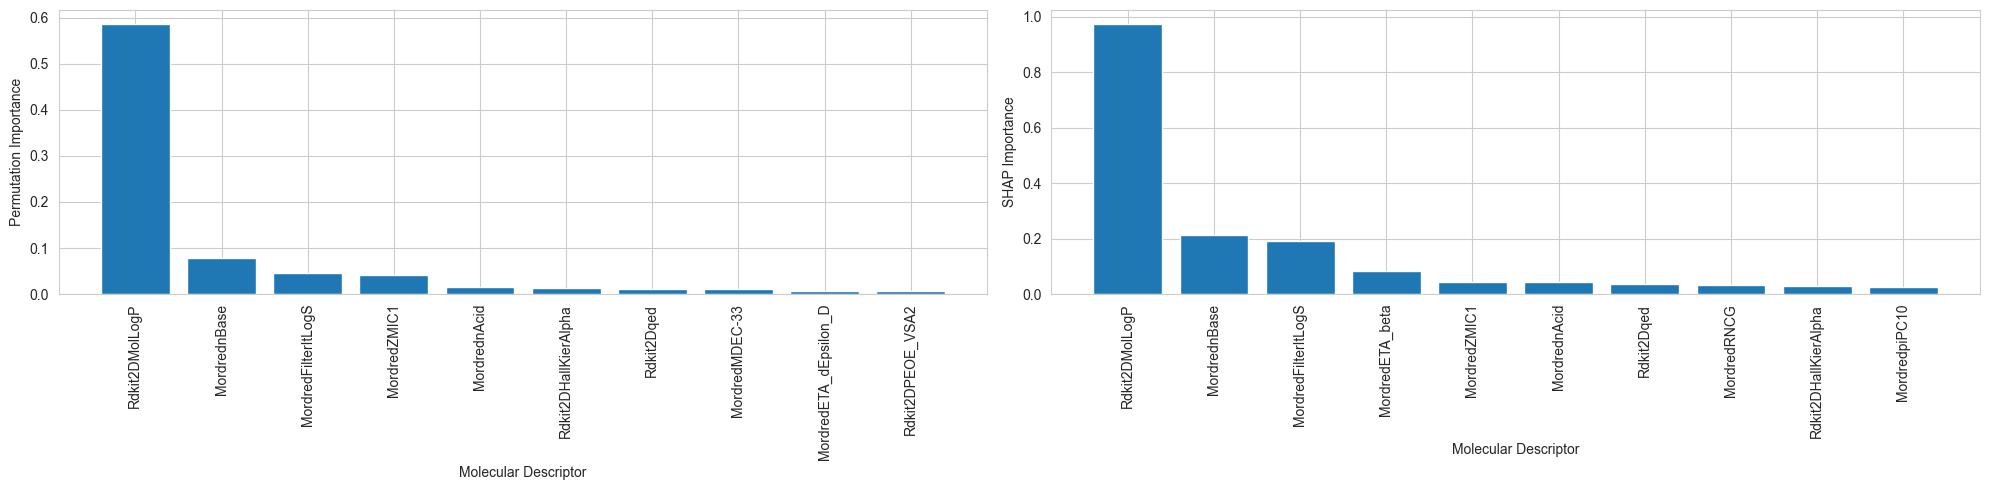

In [17]:
top100_pi_idx = pi_mean.flatten().argsort()[::-1][:10]
top100_si_idx = si_mean.flatten().argsort()[::-1][:10]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.bar(trn_X.columns[top100_pi_idx], pi_mean[top100_pi_idx, 0].tolist())
ax1.set_xlabel("Molecular Descriptor")
ax1.set_ylabel("Permutation Importance")
ax1.tick_params(axis='x', labelrotation=90)

ax2.bar(trn_X.columns[top100_si_idx], si_mean[top100_si_idx].tolist())
ax2.set_xlabel("Molecular Descriptor")
ax2.set_ylabel("SHAP Importance")
ax2.tick_params(axis='x', labelrotation=90)

plt.tight_layout()

### Choosing a subset of the most important features

If the two importance arrays have different scales, it's inappropriate to average them directly.

Our strategy is to first normalize each set of importance so their values fall within the range [0, 1], then combine them.

In [121]:
def normalize(importance):
    return (importance - np.min(importance)) / (np.max(importance) - np.min(importance))


normalized_pi_mean = normalize(pi_mean).flatten()
normalized_si_mean = normalize(si_mean).flatten()
normalized_avgmean = (normalized_pi_mean + normalized_si_mean) / 2

sorted_feats_idx = normalized_avgmean.flatten().argsort()[::-1]

In [129]:
trn = pd.read_csv("../data/normalized/TRN.csv")
tst_08SC = pd.read_csv("../data/normalized/TST_2008SC.csv")
tst1_19SC = pd.read_csv("../data/normalized/TST1_2019SC.csv")
tst2_19SC = pd.read_csv("../data/normalized/TST2_2019SC.csv")

trn_y, trn_X = trn["Solubility"], trn.drop("Solubility", axis=1)
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC.drop("Solubility", axis=1)
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC.drop("Solubility", axis=1)
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC.drop("Solubility", axis=1)

In [140]:
import torch

booster_params = {
    "eta": 0.1,
    "gamma": 1.1055210927423804,
    "alpha": 42.0,
    "lambda": 0.7993390441866357,
    "max_depth": 9,
    "min_child_weight": 5.0,
    "colsample_bytree": 0.9960479463691504,

    "objective": "reg:squarederror",

    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "booster": "gbtree",
    "eval_metric": "rmse",
    "tree_method": "auto",

    "num_boost_round": 200,
    "early_stopping_rounds": 10,
}

In [186]:
import random
from sklearn.metrics import mean_squared_error, r2_score

results = {"n_feats": [], "score": [], "metric": [], "dataset": []}

n_feats = [5, 10, 15, 20, 30, 40, 60, 80,
           100, 110, 120, 130, 140, 150, 160, 180,
           200, 250, 300, 350, 400, 450, 500, 550,
           600, 700, 800, 900, 1000, 1500, 2000, 2500, 3000, 3500, 4000]


def add_entry(data_dict, n_feats, score, metric, dataset):
    data_dict["n_feats"].append(n_feats)
    data_dict["score"].append(score)
    data_dict["metric"].append(metric)
    data_dict["dataset"].append(dataset)


for i in range(10):
    for n in n_feats:
        topn_idx = sorted_feats_idx[:n]

        booster = xgb.train(
            params={
                "eta": booster_params["eta"],
                "gamma": booster_params["gamma"],
                "alpha": booster_params["alpha"],
                "lambda": booster_params["lambda"],
                "max_depth": booster_params["max_depth"],
                "min_child_weight": booster_params["min_child_weight"],
                "colsample_bytree": booster_params["colsample_bytree"],
                "objective": "reg:squarederror",
                "device": booster_params["device"],
                "booster": booster_params["booster"],
                "eval_metric": booster_params["eval_metric"],
                "tree_method": booster_params["tree_method"],
                "seed": random.randint(1000, 9999)
            },
            dtrain=xgb.DMatrix(data=trn_X.iloc[:, topn_idx], label=trn_y),
            num_boost_round=booster_params["num_boost_round"]
        )

        # tst1_19SC #####
        tst1_19SC_pred = booster.predict(xgb.DMatrix(data=tst1_19SC_X.iloc[:, topn_idx]))
        tst1_19SC_rmse = mean_squared_error(tst1_19SC_y.values, tst1_19SC_pred, squared=False)
        tst1_19SC_r2 = r2_score(tst1_19SC_y.values, tst1_19SC_pred)

        add_entry(results, n, tst1_19SC_rmse, "RMSE", "2019SC (Tst 1)")
        add_entry(results, n, tst1_19SC_r2, "R$^2$", "2019SC (Tst 1)")

        # tst2_19SC #####
        tst2_19SC_pred = booster.predict(xgb.DMatrix(data=tst2_19SC_X.iloc[:, topn_idx]))
        tst2_19SC_rmse = mean_squared_error(tst2_19SC_y.values, tst2_19SC_pred, squared=False)
        tst2_19SC_r2 = r2_score(tst2_19SC_y.values, tst2_19SC_pred)

        add_entry(results, n, tst2_19SC_rmse, "RMSE", "2019SC (Tst 2)")
        add_entry(results, n, tst2_19SC_r2, "R$^2$", "2019SC (Tst 2)")

        # tst_08SC #####
        tst_08SC_pred = booster.predict(xgb.DMatrix(data=tst_08SC_X.iloc[:, topn_idx]))
        tst_08SC_rmse = mean_squared_error(tst_08SC_y.values, tst_08SC_pred, squared=False)
        tst_08SC_r2 = r2_score(tst_08SC_y.values, tst_08SC_pred)

        add_entry(results, n, tst_08SC_rmse, "RMSE", "2008SC (Tst)")
        add_entry(results, n, tst_08SC_r2, "R$^2$", "2008SC (Tst)")

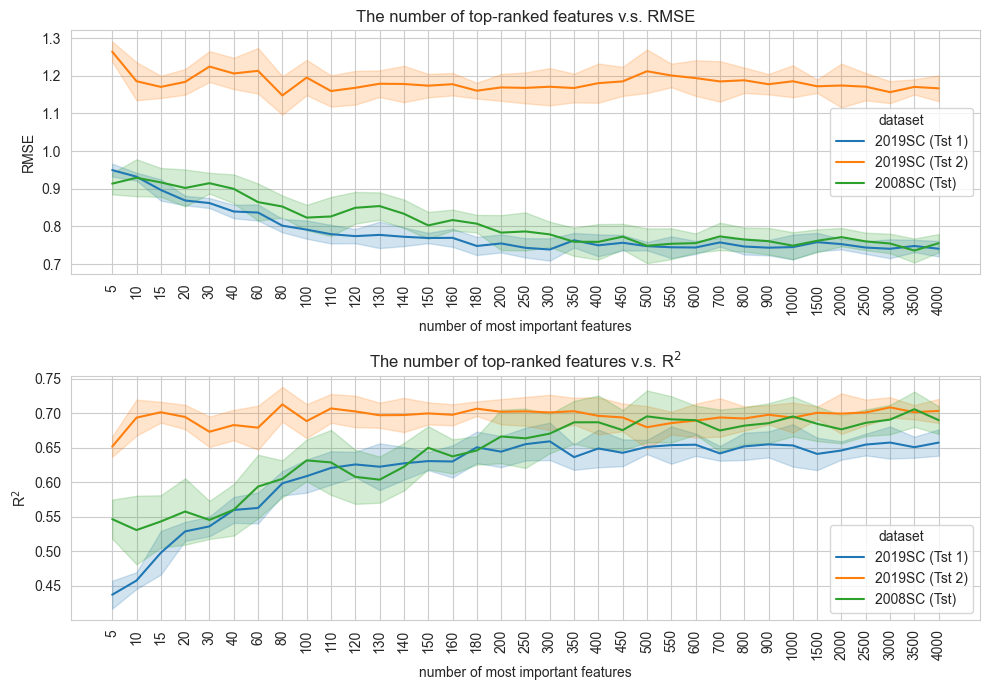

In [223]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

pd_results = pd.DataFrame(results)
pd_results['n_feats'] = pd_results['n_feats'].astype(str)

sns.lineplot(data=pd_results[pd_results["metric"] == "RMSE"],
             x="n_feats", y="score", hue="dataset", ax=ax1,
             err_style="band", errorbar=("sd", 2))
ax1.set_xlabel("number of most important features")
ax1.set_ylabel("RMSE")
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_title("The number of top-ranked features v.s. RMSE")

sns.lineplot(data=pd_results[pd_results["metric"] == "R$^2$"],
             x="n_feats", y="score", hue="dataset", ax=ax2,
             err_style="band", errorbar=("sd", 2))
ax2.set_xlabel("number of most important features")
ax2.set_ylabel("R$^2$")
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_title("The number of top-ranked features v.s. R$^2$")

plt.tight_layout()